<a href="https://colab.research.google.com/github/RegiTelma/ComputerVision/blob/main/NASNetLarge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers

In [4]:
(dataset_train_original,dataset_validate_original), info= tfds.load(
    "cats_vs_dogs",
    split=["train[:10%]","train[90%:]"], #Pretend to have a small dataset!
    as_supervised=True,
    with_info=True
)
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteUFXA0F/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path=PosixGPath('/tmp/tmpvmtoc9b7tfds'),
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
  

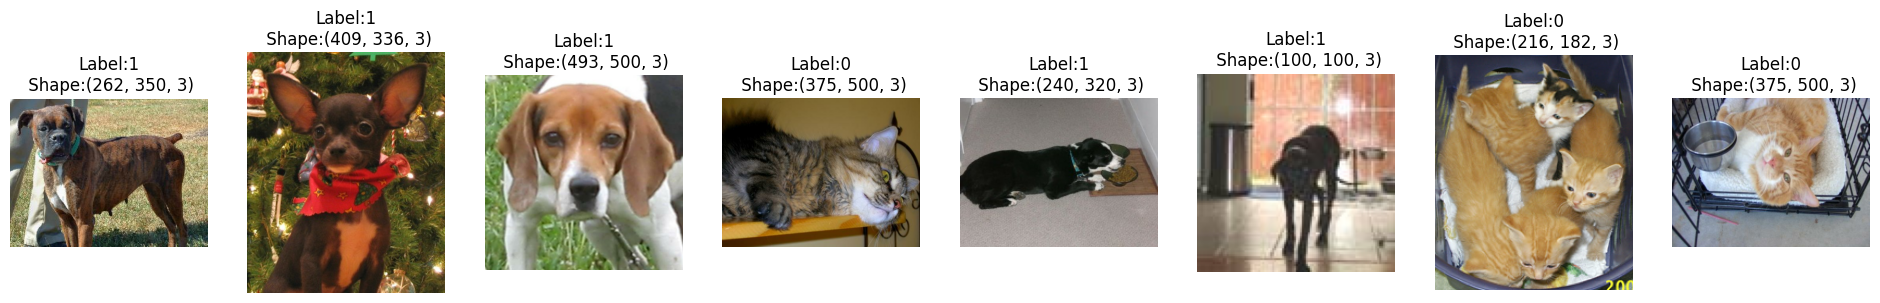

In [5]:
num_samples=8
index=1
plt.figure(figsize=(24,4))
for image,label in dataset_train_original.take(num_samples):
  plt.subplot(1,num_samples,index)
  plt.imshow(image)
  plt.title(f"Label:{label}\n Shape:{image.shape}")
  plt.axis("off")
  index+=1

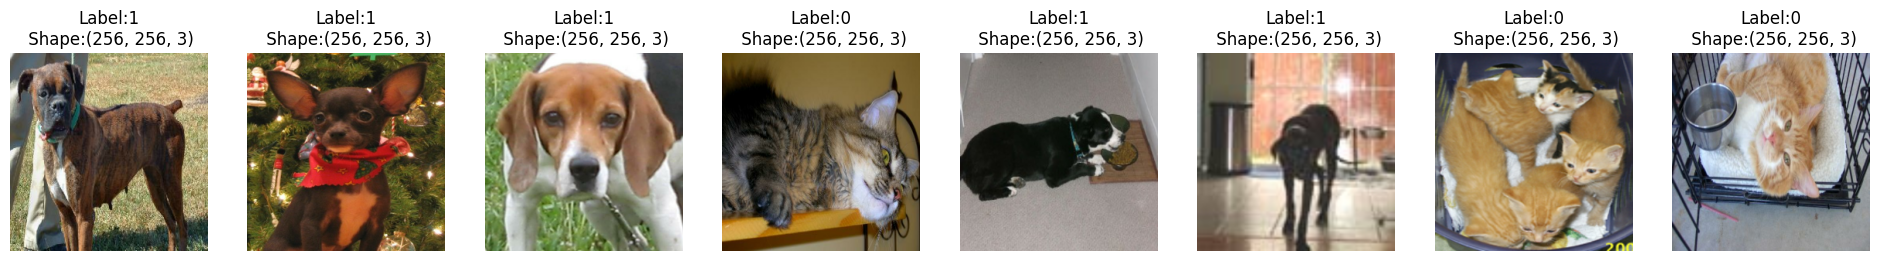

In [6]:
def encode(image,label,image_size=(256,256)): #Parameter!
  image=tf.image.convert_image_dtype(image,tf.float32)
  image=tf.image.resize(image,image_size)
  return image,label

dataset=dataset_train_original.map(lambda image,label:encode(image,label))

num_samples=8
index=1
plt.figure(figsize=(24,4))
for image,label in dataset.take(num_samples):
  plt.subplot(1,num_samples,index)
  plt.imshow(image)
  plt.title(f"Label:{label}\n Shape:{image.shape}")
  plt.axis("off")
  index+=1

In [7]:
dataset_train=dataset_train_original.map(lambda image,label:encode(image,label))
dataset_train=dataset_train.cache()
dataset_train=dataset_train.shuffle(2500)
dataset_train=dataset_train.batch(256)

dataset_validate=dataset_validate_original.map(lambda image,label:encode(image,label))
dataset_validate=dataset_validate.cache()
dataset_validate=dataset_validate.batch(256)

In [8]:
history_list={}
epochs=50

In [9]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()

def compare_histories():
    for training_name, history in history_list.items():
        plt.plot(history["val_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparison of val_accuracy")
    plt.show()
    plt.close()

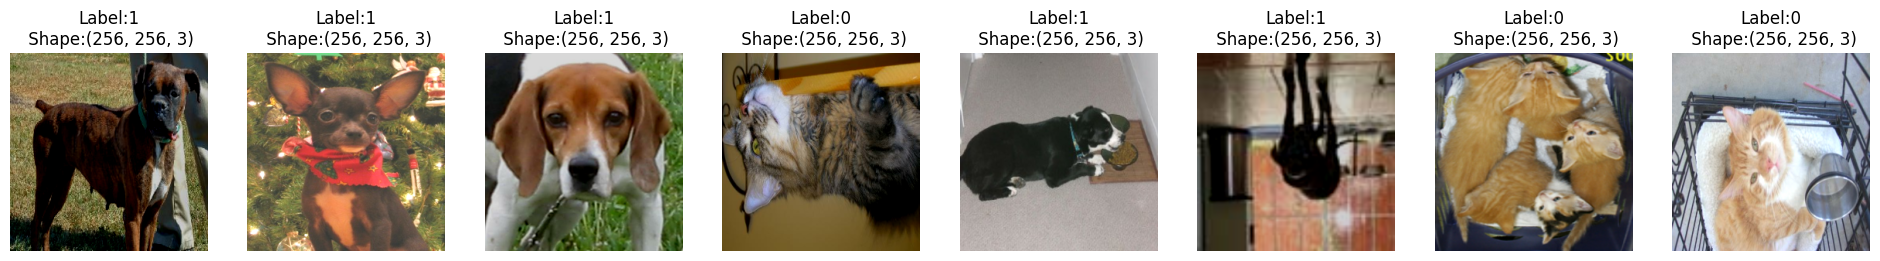

In [10]:
def augment(image,label):
  image_augmented=image
  #TODO
  image_augmented=tf.image.random_flip_left_right(image_augmented) #flip
  image_augmented=tf.image.random_flip_up_down(image_augmented)
  image_augmented=tf.image.random_brightness(image_augmented,max_delta=0.2)
  return image_augmented,label

dataset=dataset_train_original.map(lambda image,label:encode(image,label))
dataset=dataset.map(lambda image,label:augment(image,label))

num_samples=8
index=1
plt.figure(figsize=(24,4))
for image,label in dataset.take(num_samples):
  plt.subplot(1,num_samples,index)
  plt.imshow(image)
  plt.title(f"Label:{label}\n Shape:{image.shape}")
  plt.axis("off")
  index+=1

In [11]:
dataset_train_augmented=dataset_train_original.map(lambda image,label:encode(image,label))
dataset_train_augmented=dataset_train_augmented.cache()
dataset_train_augmented=dataset_train_augmented.map(lambda image,label:encode(image,label))
dataset_train_augmented=dataset_train_augmented.shuffle(2500)
dataset_train_augmented=dataset_train_augmented.batch(256)

In [ ]:
tf.keras.backend.clear_session()

base_net=tf.keras.applications.NASNetLarge(
    input_shape=(256,256,3),
    include_top=False
)
base_net.trainable=False
#base_net.summary()

model=models.Sequential()
model.add(base_net)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation="relu"))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(128,activation="relu"))
#model.add(layers.Dropout(0.35))
model.add(layers.Dense(64,activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation="sigmoid"))

model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train_augmented,
    epochs=epochs,
    validation_data=dataset_validate
)

history_list["vgg16+augment"] = history.history
render_history(history.history)
compare_histories()

343610240/343610240 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 8, 8, 4032)        84916818  
                                                                 
 flatten (Flatten)           (None, 258048)            0         
                                                                 
 dense (Dense)               (None, 256)               66060544  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                       